# Minimizar costos publicitarios

## Información del cuaderno

**Máster en Computación Cuántica - UNIR**

**Asignatura:** Algoritmos Cuánticos

**Actividad del Cuaderno por:** Albert Nieto Morales, Pablo Serrano Molinero, Sergio Cardona Tárrega

**Fecha**: 12-05-2024

---

## Enunciado

Somos una empresa interesada en que nuestro producto se conozca entre todos los miembros de una red social. Tenemos la siguiente información de dicha red:

- Mario es amigo de Sarah, Raúl y Ana.
- Enrique es amigo de Sarah y Raúl.
- Saúl es amigo de Ana.

Todas las relaciones de amistad son recíprocas, es decir, si Mario es amigo de Raúl, entonces Raúl lo es de Mario. Nuestra idea es pagar a ciertas personas para que hablen de nuestro producto a sus contactos, pero queremos pagar al menor número de personas posibles, ¿a qué personas deberíamos contratar con este fin?

Se pide que se solucione con el algoritmo QAOA, en el cual se utilizarán tres capas. Además, en este caso se deberán encontrar los mejores parámetros de rotación para las puertas U(C) y U(B) utilizando un algoritmo de búsqueda.


## Librerías y funciones

Instalaremos e importaremos las librerías necesarias para la resolución del problema

In [ ]:
%%capture
%pip install pennylane
%pip install pennylane-qulacs["cpu"]

In [ ]:
# Importaciones de PennyLane
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as npp

# Importaciones de rustworkx
import rustworkx as rx
from rustworkx.visualization import mpl_draw

# Importaciones adicionales
import cmath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Además, definiremos una serie de funciones que nos resultarán útiles a lo largo del desarrollo:
- `highest_indices`: Encuentra los índices de los valores más altos en un arreglo unidimensional.

- `highest_tensor_and_index`: Encuentra el tensor más alto y sus índices en una lista de tensores.
- `highest_phase_and_index`: Encuentra la fase más alta y su índice en una lista de fases.

- `amistades_comunes`: Número de amistades comunes entre las personas.

In [ ]:
def highest_indices(array):
    """
    Encuentra los índices de los valores más altos en un arreglo unidimensional.

    Parámetros:
    - array (array_like): El arreglo unidimensional de valores.

    Retorna:
    - indices (ndarray): Los índices de los valores más altos en el arreglo.
    - binary_indices (list): Los índices de los valores más altos en formato binario.
    """
    max_value = np.max(array)
    indices = np.where(array == max_value)[0]
    binary_indices = [bin(idx)[2:] for idx in indices]
    return indices.astype(int), binary_indices


def highest_tensor_and_index(tensors, endianness=False):
    """
    Encuentra el tensor más alto y sus índices en una lista de tensores.

    Parámetros:
    - tensors (list): La lista de tensores.
    - endianness (bool): Indica si se debe invertir el orden de los bits en los índices binarios. Por defecto es False.

    Retorna:
    - highest_index (int): El índice del tensor más alto en la lista.
    - highest_indices (list): Los índices de los bits activados en el índice binario del tensor más alto.
    """
    highest = tensors[0]
    highest_index = 0

    for i, tensor in enumerate(tensors):
        if tensor > highest:
            highest = tensor
            highest_index = i

    highest_index_binary = bin(highest_index)[2:]
    highest_index_binary = highest_index_binary[::-1] if endianness else highest_index_binary

    highest_indices = [i for i, bit in enumerate(highest_index_binary) if bit == '1']

    return highest_index, highest_indices


def highest_phase_and_index(phases):
    """
    Encuentra la fase más alta y su índice en una lista de fases.

    Parámetros:
    - phases (list): La lista de fases.

    Retorna:
    - highest_phase (float): La fase más alta en la lista.
    - highest_index (int): El índice de la fase más alta en la lista.
    - highest_index_binary (str): El índice de la fase más alta en formato binario.
    """
    highest_phase = phases[0]
    highest_index = 0

    for i, phase in enumerate(phases):
        if phase > highest_phase:
            highest_phase = phase
            highest_index = i

    highest_index_binary = bin(highest_index)[2:]

    return highest_phase, highest_index, highest_index_binary


def amistades_comunes(personas, matriz_adyacencia, persona1, persona2):
    """
    Calcula el número de amistades en común entre dos personas en una red social.

    Parámetros:
    - personas(dict): Diccionario con las personas de la red
    - matriz_adyacencia (list): Una matriz de adyacencia que representa las conexiones entre personas.
    - persona1 (str): El nombre de la primera persona.
    - persona2 (str): El nombre de la segunda persona.

    Return:
    - int: El número de amistades en común entre las dos personas.
    """
    indice1 = personas[persona1]
    indice2 = personas[persona2]
    amistades1 = matriz_adyacencia[indice1]
    amistades2 = matriz_adyacencia[indice2]
    amistades_comunes = sum([a and b for a, b in zip(amistades1, amistades2)])
    return amistades_comunes


## Definición del Problema

En esta sección definiremos el problema planteado. Para ello, lo primero que haremos será definir nuestra red de contactos a través de una lista de amistades.

In [ ]:
# Definimos la lista de amistades de nuestra red
amistades = [["Mario", "Sarah"],
             ["Mario", "Raul"],
             ["Mario", "Ana"],
             ["Enrique", "Sarah"],
             ["Enrique", "Raul"],
             ["Saul", "Ana"]]

Para poder trabajar más cómodamente, crearemos un diccionario de personas y les asociaremos a cada una un índice único.

In [ ]:
# Crear un diccionario para mapear cada persona a un índice único
personas = {}
for i, amistad in enumerate(amistades):
    for persona in amistad:
        if persona not in personas:
            personas[persona] = len(personas)

personas

{'Mario': 0, 'Sarah': 1, 'Raul': 2, 'Ana': 3, 'Enrique': 4, 'Saul': 5}

Una vez hecho esto, generaremos una matriz de adyacencia que nos indique que contactos tiene cada una de las personas. En este caso debemos de tener en cuenta que cada persona es contacto de sí misma, ya que si decidimos contactar por ejemplo a Enrique, nuestro producto llegará a Enrique y a sus contactos.

Esto nos permitirá medir de manera más adecuada el alcance de las distintas comunicaciones.


In [ ]:
# Crear matriz de adyacencia
matriz_adyacencia = [[0] * len(personas) for _ in range(len(personas))]
for amistad in amistades:
    persona1 = personas[amistad[0]]
    persona2 = personas[amistad[1]]
    matriz_adyacencia[persona1][persona2] = 1
    matriz_adyacencia[persona2][persona1] = 1
    matriz_adyacencia[persona1][persona1] = 1
    matriz_adyacencia[persona2][persona2] = 1

matriz_adyacencia

[[1, 1, 1, 1, 0, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [0, 1, 1, 0, 1, 0],
 [0, 0, 0, 1, 0, 1]]

### Grafo de la Red

Para poder visualizar de manera más sencilla la red con la que estamos trabajando, vamos a generar un grafo a partir de las diferentes personas y sus contactos.

En este grafo las relaciones de amistad vienen representadas por las aristas del grafo y cada persona por su índice en el diccionario definido anteriormente.

In [ ]:
# Cada persona será representada por un nodo
num_nodes = len(personas)

# Cada arista es una relación de amistad entre personas
edges = [(personas[amistad[0]], personas[amistad[1]], 1) for amistad in amistades]

edges

[(0, 1, 1), (0, 2, 1), (0, 3, 1), (4, 1, 1), (4, 2, 1), (5, 3, 1)]

Una vez definido el grafo, lo representamos gráficamente. Esta visualización nos será de gran utilidad ya que podemos ver claramente cual será la solución de nuestro problema.

En nuestro caso, si contactamos con la persona 3 y la persona 0, llegaríamos a todos los miembros de la red con el mínimo número de contactos.

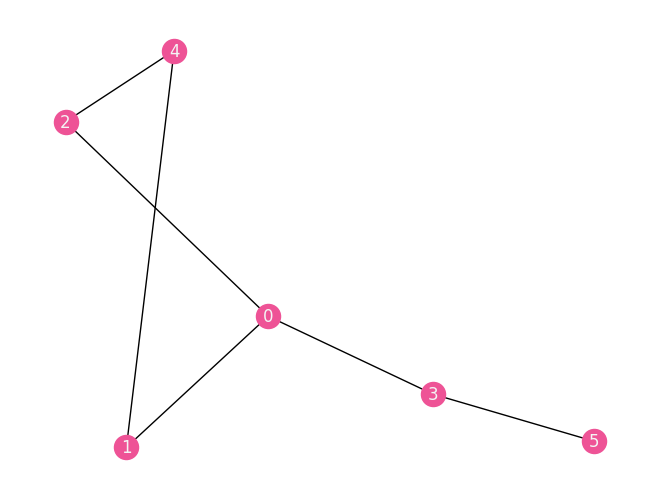

In [ ]:
# Definimos el grafo en base a sus nodos y aristas
G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

pos = rx.spring_layout(G)

# Representamos gráficamente el grafo generado
mpl_draw(
    G, pos=pos, with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

Con esta primera solución visual podemos pasar a modelizar el problema a través de la librería `Pennylane`, un framework de computación cuántica con funcionalidades muy interesantes para problemas de optimización como este.

## Formulación del problema

Una vez definidos los distintos elementos de nuestro problema, debemos pensar en como formular dicho problema de forma que lo podamos abordar con $QAOA$.

$QAOQ$ es un algoritmo de optimización que es de gran utilidad para resolver problemas de optimización, más concretamente, problemas donde el hamiltoniano que describe el sistema que queremos optimizar sea de tipo Ising.

El modelo de Ising es un modelo muy similar al QUBO, estudiado en la anterior práctica, pero en este caso las variables binarias en vez de ser $x_i \in \{0,1\}$ son $z_i \in \{-1,1\}$.

Con esta definición, una vía para abordar este problema será la de formularlo como un problema QUBO y posteriormente ajustarlo para que sea tipo Ising. Esta transformación se puede hacer de manera relativamente sencilla mediante el cambio de variable $x_i = \frac{1-z_i}{2}$.

### Formulación QUBO

Un problema QUBO tiene la siguiente estructura:

Minimizar:
$$f(x) = \sum_{i=1}^{n} q_i x_i + \sum_{i=1}^{n}\sum_{j=i+1}^{n} q_{ij} x_i x_j$$

Sujeto a:
$$x_i \in \{0, 1\}, \text{ para } i = 1, 2, ..., n$$

Donde:

- $x_i$ son variables binarias que representan las decisiones del problema.
- $q_i$ son los coeficientes de los términos lineales que representan el costo o beneficio de seleccionar cada variable individualmente.
- $q_{ij}$ son los coeficientes de los términos cuadráticos que representan el costo o beneficio de seleccionar simultáneamente las variables $x_i , x_j$.

- La función objetivo $f(x)$ es la expresión que se desea minimizar.
- La restricción $x_i \in \{0,1\}$ indica que las variables son binarias, es decir, pueden tomar solo los valores 0 o 1.

Si el problema QUBO en cuestión tuviese restricciones, estas se añadirían a la función de coste mediante el uso de multiplicadores de Lagrange.

$$f(x) = \sum_{i=1}^{n} q_i x_i + \sum_{i=1}^{n}\sum_{j=i+1}^{n} q_{ij} x_i x_j - \lambda (g(x_i) -c)$$

Donde:
- $\lambda$ es el multiplicador de lagrande asociado a la restricción.
- La restricción vendría definida por $g(x_i) = c$.


Una vez entendida la estructura que debe de tener la formulación de nuestro problema, vamos a bajarlo a tierra. Para ello, dividiremos la función a optimizar en unidades más sencillas de comprender.

En nuestro caso queremos minimizar el número de contactos a los que pagamos para que hablen de nuestro producto, manteniendo una cobertura total de la red, por lo tanto podemos dividir nuestra función de coste en 2 partes:

1. $C(x_i)$: Número de contactos a los que pagamos
2. $g(x_i)$: Penalización si con los contactos seleccionados no cubrimos toda la red.

Donde las variables $x_i$ serán 1 si contactamos a esa persona y 0 si no.

De esta forma definimos $$f(x_i) = C(x_i) - \lambda g(x_i)$$

La función $C(x_i)$ es la más sencilla de las dos ya que la podemos definir simplemente como:

$$C(x_i) = \sum_{i=1}^n x_i$$

Donde simplemente contaremos cuantas personas hemos contactado para que publiciten nuestro producto sumando cuales de ellas están a 1.

Por otro lado la funcíon $g(x_i)$ será la encargada de penalizar si no se contactasen a todas las personas de la red. Para modelizar esto volveremos a subdividir la función en dos:

1. Número de personas a las que llegas si contactas a la persona $x_i$.
2. Número de personas redundantes si contactas a las personas $x_i,x_j$.

Para definir estas nuevas funciones primero introduciremos dos parámetros de las mismas.
- $n_i$: Número de contactos de la persona $x_i$.
- $n_{ij}$: Número de contactos comunes entre $x_i,x_j$.

Podemos definir entonces:

$$g_1(x_i) = \sum_{i=1}^n n_i x_i$$

$$g_2(x_i) = -\sum_{i=1}^n \sum_{j=1+1}^n n_{ij} x_i x_j$$

Por lo que la función de penalización $g(x_i) = g_1(x_i) + g_2(x_i) - N$ donde $N$ es el número total de personas dentro de nuestra red.  

Como resultado hemos obtenido la siguiente función a optimizar:

$$f(x) = \sum_{i=1}^n x_i - \lambda (\sum_{i=1}^n n_i x_i -\sum_{i=1}^n \sum_{j=1+1}^n n_{ij} x_i x_j - N)$$

### Formulación Ising

Una vez tenemos nuestro problema formulado como un problema de tipo QUBO, debemos transformarlo en Ising con el cambio de variable que hemos mencionado anteriormente. Análogamente al caso anterior dividiremos el problema en unidades más pequeñas para que sea más sencillo.


1. $C(z_i)$: Número de contactos a los que pagamos


$$C_1(z_i) = \frac{N}{2} - \frac{1}{2} \sum_{i=1}^ n (z_i) $$

2. $g(z_i)$: Penalización si con los contactos seleccionados no cubrimos toda la red.

$$g_1(z_i) = \sum_{i=1}^ n\frac{n_i}{2} - \frac{1}{2} \sum_{i=1}^ n (n_i z_i) $$
3. El número de personas a las que alcanzamos de forma redundante si contactamos a dos pares de personas concretos:

$$g_2(z) = -\frac{1}{4}\sum_{i=1}^ n \sum_{j=i+1}^ n (n_{ij} (z_i + z_j - z_i z_j - 1)) $$


Por último, cabe destacar que como el algoritmo $QAOA$ está pensado para maximizar, y nosotros buscamos minimizar, aplicaremos un signo menos a los coeficientes.

## Programación del problema

### Resolución en base al modelo Ising

Los primeros pasos en la definición de nuestro problema será la generación de las variables:

- `Num_contactos`: Número de contactos de cada persona de la red (incluído él mismo).
- `Matriz_comunes`: Matriz de contactos comunes entre miembros de la red.

In [ ]:
# Número de contactos de cada persona
for persona, indice in personas.items():
    contactos = sum(matriz_adyacencia[indice])
    print(f"{persona} supone {contactos} contactos.")

# Encontramos el número de contactos de cada persona
num_contactos = [sum(fila) for fila in matriz_adyacencia]
num_contactos

Mario supone 4 contactos.
Sarah supone 3 contactos.
Raul supone 3 contactos.
Ana supone 3 contactos.
Enrique supone 3 contactos.
Saul supone 2 contactos.


[4, 3, 3, 3, 3, 2]

Comprobamos cada pareja de amistades cuántos contactos en común tienen.

In [ ]:
# Encontramos el número de amistades comunes entre las personas
for persona1, indice1 in personas.items():
    for persona2, indice2 in personas.items():
        if persona1 < persona2:
            comunes = amistades_comunes(personas, matriz_adyacencia, persona1, persona2)
            print(f"{persona1} y {persona2} tienen {comunes} contactos en común.")

Mario y Sarah tienen 2 contactos en común.
Mario y Raul tienen 2 contactos en común.
Mario y Saul tienen 1 contactos en común.
Sarah y Saul tienen 0 contactos en común.
Raul y Sarah tienen 2 contactos en común.
Raul y Saul tienen 0 contactos en común.
Ana y Mario tienen 2 contactos en común.
Ana y Sarah tienen 1 contactos en común.
Ana y Raul tienen 1 contactos en común.
Ana y Enrique tienen 0 contactos en común.
Ana y Saul tienen 2 contactos en común.
Enrique y Mario tienen 2 contactos en común.
Enrique y Sarah tienen 2 contactos en común.
Enrique y Raul tienen 2 contactos en común.
Enrique y Saul tienen 0 contactos en común.


Definimos una matriz con los contactos comunes que posteriormente utilizaremos para la resolución:

In [ ]:
# Hacemos una matriz con los contactos comunes
matriz_comunes = [[amistades_comunes(personas,matriz_adyacencia, persona1, persona2) for persona2 in personas] for persona1 in personas]
matriz_comunes

[[4, 2, 2, 2, 2, 1],
 [2, 3, 2, 1, 2, 0],
 [2, 2, 3, 1, 2, 0],
 [2, 1, 1, 3, 0, 2],
 [2, 2, 2, 0, 3, 0],
 [1, 0, 0, 2, 0, 2]]

#### Definición del Hamiltoniano

A continuación, definimos los coeficientes de nuestro Hamiltoniano Ising. Nuestro Hamiltioniano se separa en tres partes:
- Número de personas contactadas.
- Número de contactos que tiene cada persona.
- Contactos comunes entre personas.

In [ ]:
# Lambda de la penalización
lambda_ = 12
# Coeficientes asociados al término que nos indica el número de personas contactadas
coefs_1 = [1 for _ in range(len(personas))]

coefs_1

[1, 1, 1, 1, 1, 1]

In [ ]:
# Coeficientes asociados al número de contactos que tiene cada persona
coefs_2 = [-lambda_ * num_contactos[i] for i in range(len(personas))]

coefs_2

[-48, -36, -36, -36, -36, -24]

In [ ]:
# Coeficientes asociados a los contactos comunes entre personas
coefs_3 = [0.5*lambda_ * matriz_comunes[i][j] for i in range(len(personas)) for j in range(i+1, len(personas))]

# Debido a la naturaleza de esta última parte del Hamiltoniano, debemos expandir los coeficientes, ya que cada coeficiente se debe aplicar
# a -zi,-zj, zizj
coefs_3_exp = np.outer(coefs_3, [1,1,-1])

# Pasamos la matriz a un vector
coefs_3_exp = coefs_3_exp.flatten().tolist()

coefs_3

[12.0,
 12.0,
 12.0,
 12.0,
 6.0,
 12.0,
 6.0,
 12.0,
 0.0,
 6.0,
 12.0,
 0.0,
 0.0,
 12.0,
 0.0]

Habiendo definido el coeficiente de las tres partes, los unimos en una única variable.

In [ ]:
# Unimos los coeficientes definidos para las distintas partes de nuestro problema
coefs = coefs_1+coefs_2+coefs_3_exp

Tenienido definidos los coeficientes, ahora nos falta definir el circuito asociado a nuestro problema.

In [ ]:
# Número de qubits
n = len(personas)

# Lista vacía de transformaciones de nuestro circuito
obs = []

# Puertas asociadas a los términos de f1
for i in range(n):
  obs.append(qml.PauliZ(i))

# Puertas asociadas a los términos de f2
for i in range(n):
  obs.append(qml.PauliZ(i))

# Puertas asociadas a los términos de f3
for i in range(n):
  for j in range(i+1,n):
    obs.append(qml.PauliZ(i))
    obs.append(qml.PauliZ(j))
    obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

# Vemos la estructura que tendrá el circuito asociado a nuestro Hamiltoniano
obs

[Z(0),
 Z(1),
 Z(2),
 Z(3),
 Z(4),
 Z(5),
 Z(0),
 Z(1),
 Z(2),
 Z(3),
 Z(4),
 Z(5),
 Z(0),
 Z(1),
 Z(0) @ Z(1),
 Z(0),
 Z(2),
 Z(0) @ Z(2),
 Z(0),
 Z(3),
 Z(0) @ Z(3),
 Z(0),
 Z(4),
 Z(0) @ Z(4),
 Z(0),
 Z(5),
 Z(0) @ Z(5),
 Z(1),
 Z(2),
 Z(1) @ Z(2),
 Z(1),
 Z(3),
 Z(1) @ Z(3),
 Z(1),
 Z(4),
 Z(1) @ Z(4),
 Z(1),
 Z(5),
 Z(1) @ Z(5),
 Z(2),
 Z(3),
 Z(2) @ Z(3),
 Z(2),
 Z(4),
 Z(2) @ Z(4),
 Z(2),
 Z(5),
 Z(2) @ Z(5),
 Z(3),
 Z(4),
 Z(3) @ Z(4),
 Z(3),
 Z(5),
 Z(3) @ Z(5),
 Z(4),
 Z(5),
 Z(4) @ Z(5)]

Teniendo ambos coeficientes y circuito del Hamiltoniano, podemos definir el Hamiltoniano con la clase integrada en Pennylane.

In [ ]:
# Definimos nuestro Hamiltoniano haciendo uso de los circuitos generados y de sus coeficientes asociados
H = qml.Hamiltonian(coefs, obs)
H

(
    1 * Z(0)
  + 1 * Z(1)
  + 1 * Z(2)
  + 1 * Z(3)
  + 1 * Z(4)
  + 1 * Z(5)
  + -48 * Z(0)
  + -36 * Z(1)
  + -36 * Z(2)
  + -36 * Z(3)
  + -36 * Z(4)
  + -24 * Z(5)
  + 12.0 * Z(0)
  + 12.0 * Z(1)
  + -12.0 * (Z(0) @ Z(1))
  + 12.0 * Z(0)
  + 12.0 * Z(2)
  + -12.0 * (Z(0) @ Z(2))
  + 12.0 * Z(0)
  + 12.0 * Z(3)
  + -12.0 * (Z(0) @ Z(3))
  + 12.0 * Z(0)
  + 12.0 * Z(4)
  + -12.0 * (Z(0) @ Z(4))
  + 6.0 * Z(0)
  + 6.0 * Z(5)
  + -6.0 * (Z(0) @ Z(5))
  + 12.0 * Z(1)
  + 12.0 * Z(2)
  + -12.0 * (Z(1) @ Z(2))
  + 6.0 * Z(1)
  + 6.0 * Z(3)
  + -6.0 * (Z(1) @ Z(3))
  + 12.0 * Z(1)
  + 12.0 * Z(4)
  + -12.0 * (Z(1) @ Z(4))
  + 0.0 * Z(1)
  + 0.0 * Z(5)
  + -0.0 * (Z(1) @ Z(5))
  + 6.0 * Z(2)
  + 6.0 * Z(3)
  + -6.0 * (Z(2) @ Z(3))
  + 12.0 * Z(2)
  + 12.0 * Z(4)
  + -12.0 * (Z(2) @ Z(4))
  + 0.0 * Z(2)
  + 0.0 * Z(5)
  + -0.0 * (Z(2) @ Z(5))
  + 0.0 * Z(3)
  + 0.0 * Z(4)
  + -0.0 * (Z(3) @ Z(4))
  + 12.0 * Z(3)
  + 12.0 * Z(5)
  + -12.0 * (Z(3) @ Z(5))
  + 0.0 * Z(4)
  + 0.0 * Z(5)
  + -0

#### Implementación del algoritmo QAOA

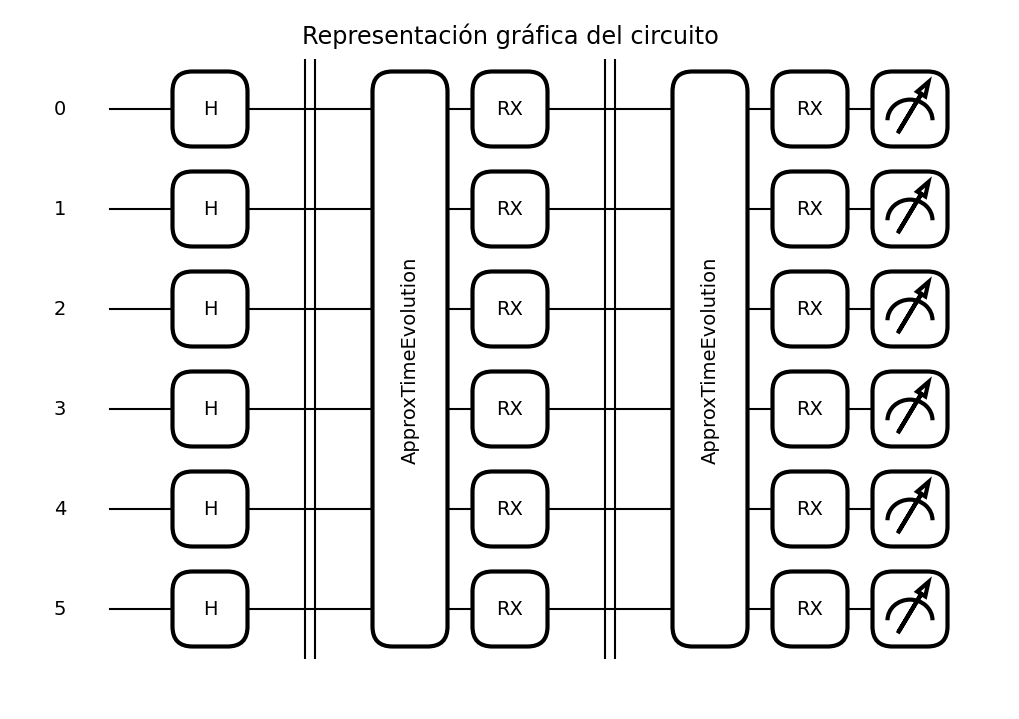

In [ ]:
# Definimos el parámetro gamma de separación de fase
gamma = 1

# Definimos el parámetro beta de rotación para pasar de fase a amplitud
beta = 1

# Número de iteraciones del circuito
iter = 60

# Definimos el entorno que utilizaremos para las ejecuciones
dev = qml.device("default.qubit", wires = H.wires)

# Definimos un circuito análogo al anterior pero con el operador U(beta)
@qml.qnode(dev)

def circuit(H, gamma, beta, iter = 1,):
    """
    Construye un circuito cuántico para el algoritmo Quantum Approximate Optimization Algorithm (QAOA).

    Parámetros:
    - H(list): Hamiltoniano Ising del sistema
    - gamma(float): Parámetro gamma para la separación en fases
    - beta(float): Parámetro de la rotación RX para modificar las amplitudes en función de las fases
    - iter (int): El número de iteraciones del algoritmo QAOA. Por defecto es 1.

    Retorna:
    - qml.state(): El estado final del sistema cuántico después de aplicar el circuito.
    """

    for i in dev.wires:
        qml.Hadamard(wires = i)

    for _ in range(iter):
        qml.Barrier(wires = dev.wires)
        qml.ApproxTimeEvolution(H, -gamma, 1)
        for i in dev.wires:
            qml.RX(-beta, wires = i)

    return qml.state()

# Representamos una versión reducida el circuito generado
fig, ax = qml.draw_mpl(circuit)(H, gamma, beta,iter=2)
fig.suptitle("Representación gráfica del circuito", fontsize="xx-large")

plt.show()

#### Resultados

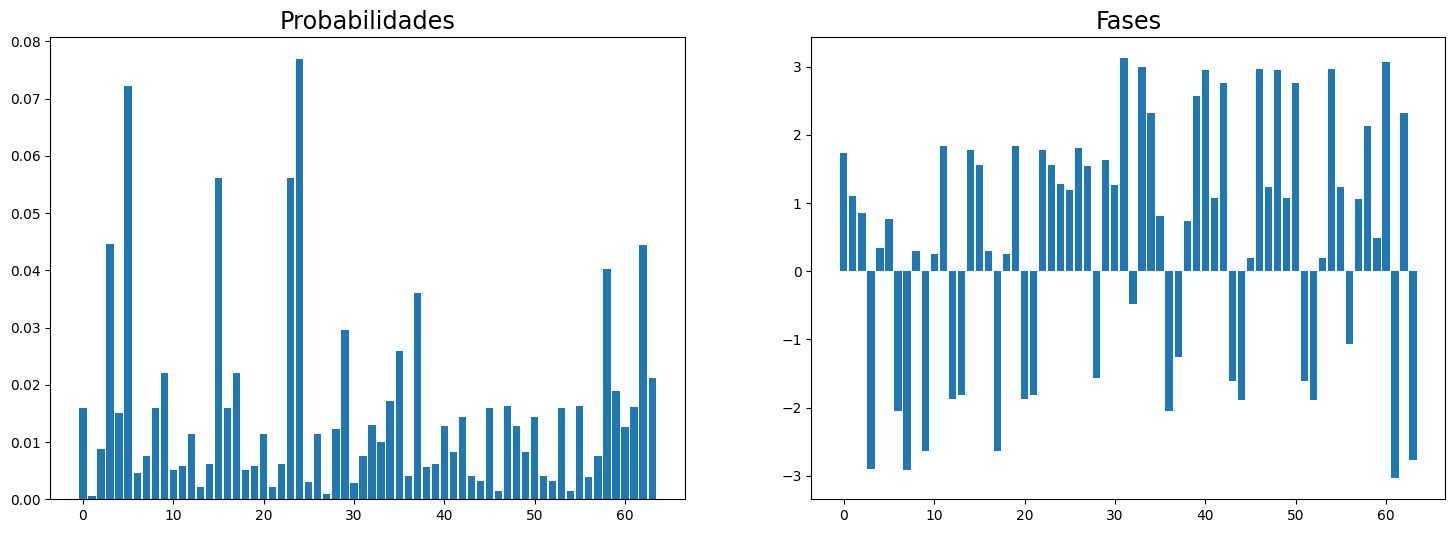

In [ ]:
# Creamos la figura y los ejes para las subfiguras
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graficamos las probabilidades en la segunda subfigura
axes[0].set_title("Probabilidades", fontsize="xx-large")
probs = [abs(i)**2 for i in circuit(H, gamma, beta, iter)]
axes[0].bar(range(len(probs)), probs)

# Graficamos las fases en la tercera subfigura
axes[1].set_title("Fases", fontsize="xx-large")
phases = [cmath.phase(i) for i in circuit(H, gamma, beta, iter)]
axes[1].bar(range(len(phases)), phases)

plt.show()

In [ ]:
# Escribimos por pantalla el resultado más probable, es decir, la solución encontrada a nuestro problema
print(f"El estado más probable es: {probs.index(max(probs))}, asociado al número binario {bin(probs.index(max(probs)))}")

El estado más probable es: 24, asociado al número binario 0b11000


Vemos que este resultado es el asociado a contactar al nodo 3 y 4, de forma que cubriríamos toda la red con 2 únicos contactos.

Este es el resultado óptimo, pero para llegar a él necesitamos un número grande de iteraciones. Como sabemos $QAOA$ es un algoritmo que se va aproximando al resultado óptimo, por lo que podemos reducir el número de iteraciones a costa de la posibilidad de encontrar una solución que no sea la óptima, pero se acerque a ella.

En el siguiente punto veremos una forma alternativa de resolver este problema, en la que usaremos menos capas para obtener una solución aproximada.

 ### Resolución como problema de cobertura mínima de vértices

Utilizando las funciones implementadas en Pennylane, podemos intentar resolver este problema como un problema de cobertura mínima de vértices. Es decir, intentamos cubrir toda la red de amistades con el mínimo número de vértices.

Tenemos el siguiente grafo para definir el problema, previamente definido:

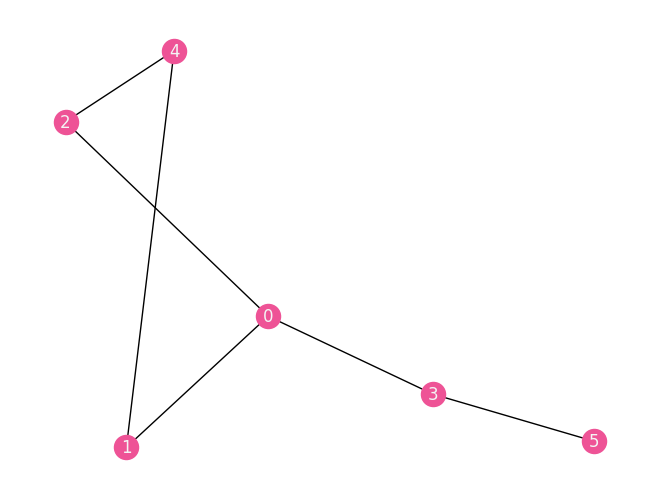

In [ ]:
mpl_draw(
    G, pos=pos, with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

#### Definición del Hamiltoniano

El módulo QAOA de PennyLane tiene una colección de problemas de optimización incorporados, incluida la cobertura de vértice mínima. Para cada problema, puede recuperar el Hamiltoniano de coste, así como un Hamiltoniano mezclador recomendado.

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(G, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(0) @ Z(3)) + 0.75 * Z(0) + 0.75 * Z(3) + 0.75 * (Z(4) @ Z(1)) + 0.75 * Z(4) + 0.75 * Z(1) + 0.75 * (Z(4) @ Z(2)) + 0.75 * Z(4) + 0.75 * Z(2) + 0.75 * (Z(5) @ Z(3)) + 0.75 * Z(5) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3) + -1.0 * Z(4) + -1.0 * Z(5)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4) + 1 * X(5)


Creamos la capa que consiste en el circuito del QAOA que queremos repetir, especificando gamma y alpha como futuros parámetros.

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

#### Implementación del algoritmo QAOA
Utilizaremos tantos qubits como personas en la red y como se ha definido en el problema, utilizaremos una profundidad del QAOA de 3. Luego definimos el circuito.

In [ ]:
wires = range(num_nodes)
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

La función de coste es el valor esperado de HC que queremos minimizar. Utilizamos la función expval() que devuelve el valor de la expectativa del Hamiltoniano con respecto al estado de salida del circuito. También definimos el dispositivo en el que se realiza la simulación.

In [ ]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

La optimización la haremos con Gradient Descent que proporciona PennyLane. Se hará $70$ veces y el valor inicial que le daremos a alpha y gamma será de $0.5$.

In [ ]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
gb = [[0.5]*depth] * 2
params = npp.array(gb, requires_grad=True)
gb

[[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

Tras unos minutos, obtenemos parámetros óptimos para cada capa del QAOA.

In [ ]:
for _ in range(steps):
  params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.54746346 0.4923788  0.86671131]
 [0.58571054 0.49269125 1.01184449]]


Con los parámetros óptimos, ahora podemos reconstruir el paisaje de probabilidades. Redefinimos el circuito QAOA completo con los parámetros óptimos, pero esta vez devolvemos las probabilidades de medir cada cadena de bits:

In [ ]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

#### Resultados
Podemos ver que obtenemos varias máximas.

<ipython-input-30-327e102c19bb>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


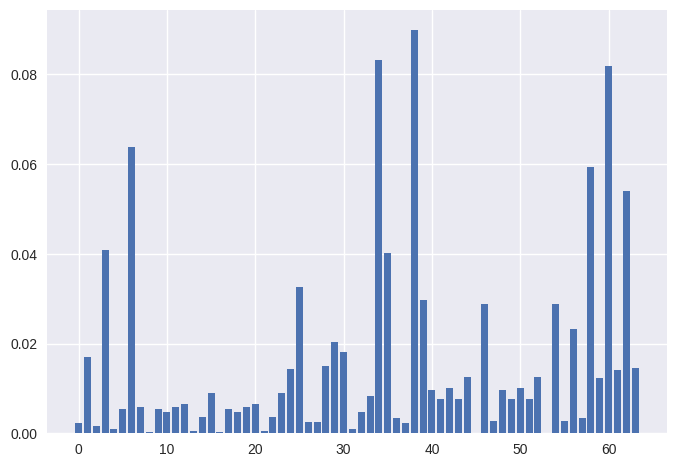

In [ ]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

Recordemos cuáles son los índices y la matriz de adyaciencia de las amistades.

In [ ]:
df_ady = pd.DataFrame(matriz_adyacencia, columns=personas.keys(), index=personas.keys())
df_ady

,Mario,Sarah,Raul,Ana,Enrique,Saul
Mario,1,1,1,1,0,0
Sarah,1,1,0,0,1,0
Raul,1,0,1,0,1,0
Ana,1,0,0,1,0,1
Enrique,0,1,1,0,1,0
Saul,0,0,0,1,0,1


Visualizando los resultados y ordenándolos por mayor probabilidad, vemos que aquellas probabilidades máximas son aquellas con el mínimo número de vértices.

In [ ]:
df = pd.DataFrame(probs, columns=['Probability'])
df.index.names = ['Result']
df['Binary'] = df.index.map(lambda x: format(x, '0{}b'.format(num_nodes)))
df = df.sort_values('Probability', ascending=False)
df

,Probability,Binary
Result,,
38,0.089928,100110
34,0.083166,100010
60,0.081857,111100
6,0.063780,000110
58,0.059469,111010
...,...,...
13,0.000483,001101
8,0.000256,001000
16,0.000256,010000


Vemos que conseguimos una de las mejores opciones con más probabilidad. Para poder conseguir el mejor resultado que sería el nodo 3 y 4, el cual está en 4a posición, se debería añadir más capas.

## Conclusiones

Vemos que hemos sido capaces de resolver el problema de forma manual o con funciones ya implementadas. Hemos podido implementar el QAOA utlizando PennyLane y aplicado un algoritmo de optimización para los parámetros alpha y gamma.

Además el código presentado está diseñado para cualquier tipo de input, ya sean cadenas de texto o números.